In [11]:
%reset

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


ATPPRT
PRATPP
ATPS4rpp
DHAtpp
GUAtpp
DATPHs
ATPHs
ECAtpp
UREAtpp
ATPM
FUSAtpp
LIPATPT
ALAtpp
URAtpp


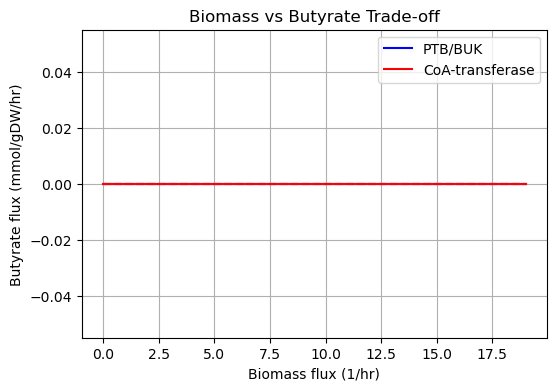

Max butyrate flux (PTB/BUK) = 9.99999999999975
Max butyrate flux (CoA-transferase) = 9.999999999999577
ATP per butyrate (PTB/BUK) = -6.217248937901003e-16
ATP per butyrate (CoA-transferase) = 3.2634394745744014e-16


In [12]:
import cobra
from cobra import Reaction, Metabolite
from cobra.flux_analysis import production_envelope
import matplotlib.pyplot as plt
import copy
import pandas as pd

# ----------------------------
# 1) Load base model
EC_model_PTB_BUK = cobra.io.load_matlab_model("iML1515.mat")

#Second model for CoA-transferase pathway
EC_model_CoA = copy.deepcopy(EC_model_PTB_BUK)

# ----------------------------
# 3) Reaction adding function
# ----------------------------
def add_rxn(model, rxn_id, name, stoich, reversible=True):
    if rxn_id in model.reactions:
        return  # skip if already exists
    
    rxn = Reaction(rxn_id)
    rxn.name = name
    rxn.lower_bound = -1000 if reversible else 0
    rxn.upper_bound = 1000
    
    mets = {}
    for met_id, coeff in stoich.items():
        if met_id not in model.metabolites:
            model.add_metabolites([Metabolite(met_id)])
        mets[model.metabolites.get_by_id(met_id)] = coeff
    rxn.add_metabolites(mets)
    model.add_reactions([rxn])

# ----------------------------
# 4) Add PTB/BUK pathway
# ----------------------------
# Steps 1-4 are shared with CoA-transferase
shared_steps = [
    ("BUT1_THIOLASE", "Acetyl-CoA acetyltransferase", {"accoa_c": -2, "aacoa_c": 1, "coa_c": 1}),
    ("BUT2_HBD", "3-hydroxybutyryl-CoA dehydrogenase", {"aacoa_c": -1, "nadh_c": -1, "h_c": -1, "3hbcoa_c": 1, "nad_c": 1}, False),
    ("BUT3_CRT", "Crotonase", {"3hbcoa_c": -1, "crocoa_c": 1, "h2o_c": 1}),
    ("BUT4_BCD", "Butyryl-CoA dehydrogenase", {"crocoa_c": -1, "nadh_c": -1, "h_c": -1, "btcoa_c": 1, "nad_c": 1}, False)
]

for step in shared_steps:
    if len(step) == 4:
        add_rxn(EC_model_PTB_BUK, *step)
        add_rxn(EC_model_CoA, *step)
    else:
        add_rxn(EC_model_PTB_BUK, step[0], step[1], step[2])
        add_rxn(EC_model_CoA, step[0], step[1], step[2])

# Step 5 PTB/BUK (ATP-consuming)
add_rxn(EC_model_PTB_BUK,"BUT5A_PTB","Phosphate butyryltransferase", {"btcoa_c": -1,"pi_c": -1,"btp_c": 1,"coa_c": 1})
add_rxn(EC_model_PTB_BUK,"BUT5B_BUK","Butyrate kinase", {"btp_c": -1,"adp_c": -1,"but_c": 1,"atp_c": 1}, reversible=False)

# Step 5 CoA-transferase (ATP-free)
add_rxn(EC_model_CoA,"BUT_COAT","Butyryl-CoA:acetate CoA-transferase", {"btcoa_c": -1, "ac_c": -1, "but_c": 1, "accoa_c": 1}, reversible=False)

# Step 6 export (both pathways)
add_rxn(EC_model_PTB_BUK,"BUTYRATE_EXPORT","Butyrate export", {"but_c": -1, "but_e": 1}, reversible=False)
add_rxn(EC_model_CoA,"BUTYRATE_EXPORT","Butyrate export", {"but_c": -1, "but_e": 1}, reversible=False)

# ----------------------------
# 5) Set ATP maintenance
# ----------------------------
# Check correct reaction ID
for r in EC_model_PTB_BUK.reactions:
    if "atp" in r.id.lower():
        print(r.id)  # usually 'ATPM' or 'ATPM_maintenance'

EC_model_PTB_BUK.reactions.ATPM.lower_bound = 10
EC_model_CoA.reactions.ATPM.lower_bound = 10

# ----------------------------
# 6) Set gut-like medium
# ----------------------------
gut_medium = {
    'EX_glc__D_e': 5.0,
    'EX_nh4_e': 1000.0,
    'EX_pi_e': 1000.0,
    'EX_so4_e': 1000.0,
    'EX_k_e': 1000.0,
    'EX_na1_e': 1000.0,
    'EX_h2o_e': 1000.0,
    'EX_co2_e': 1000.0,
    'EX_h_e': 1000.0,
    'EX_ac_e': 10.0,
    'EX_but_e': 0.0,
    'EX_o2_e': 0.0
}

def apply_medium(model, medium):
    for ex in model.exchanges:
        ex.lower_bound = 0  # block uptake by default
        ex.upper_bound = 1000
    for ex_id, val in medium.items():
        if ex_id in model.reactions:
            model.reactions.get_by_id(ex_id).lower_bound = -val  # uptake negative

apply_medium(EC_model_PTB_BUK, gut_medium)
apply_medium(EC_model_CoA, gut_medium)

# ----------------------------
# 7) Production envelope
# ----------------------------
def find_biomass_rxn(m):
    for r in m.reactions:
        if "biomass" in r.id.lower() or "biomass" in r.name.lower():
            return r
    raise RuntimeError("Biomass reaction not found.")

biomass_rxn_PTB = find_biomass_rxn(EC_model_PTB_BUK)
biomass_rxn_CoA = find_biomass_rxn(EC_model_CoA)

def plot_tradeoff(model, biomass_rxn, color, label):
    env = production_envelope(
    model,
    reactions=["EX_but_e"],      # use correct keyword for your COBRA version
    objective=biomass_rxn,       # pass reaction object
    points=20)

    # always convert to DataFrame
    env = pd.DataFrame(env)
    x = env.index.values
    plt.plot(x, env["flux_minimum"], "--", color=color)
    plt.plot(x, env["flux_maximum"], color=color, label=label)

plt.figure(figsize=(6,4))
plot_tradeoff(EC_model_PTB_BUK, biomass_rxn_PTB, "blue", "PTB/BUK")
plot_tradeoff(EC_model_CoA, biomass_rxn_CoA, "red", "CoA-transferase")
plt.xlabel("Biomass flux (1/hr)")
plt.ylabel("Butyrate flux (mmol/gDW/hr)")
plt.title("Biomass vs Butyrate Trade-off")
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------
# 8) Max butyrate flux
# ----------------------------
def max_butyrate_flux(model):
    model.objective = "BUTYRATE_EXPORT"
    sol = model.optimize()
    return sol.objective_value

print("Max butyrate flux (PTB/BUK) =", max_butyrate_flux(EC_model_PTB_BUK))
print("Max butyrate flux (CoA-transferase) =", max_butyrate_flux(EC_model_CoA))

# ----------------------------
# 9) ATP per butyrate
# ----------------------------
def net_atp_per_butyrate(model, butyrate_rxn="BUTYRATE_EXPORT"):
    model.objective = butyrate_rxn
    sol = model.optimize()
    net_atp = 0.0
    for rxn_id, flux in sol.fluxes.items():
        rxn = model.reactions.get_by_id(rxn_id)
        for met, coeff in rxn.metabolites.items():
            if met.id == "atp_c":
                net_atp += coeff * flux
    if sol.fluxes[butyrate_rxn] == 0:
        return 0
    return net_atp / sol.fluxes[butyrate_rxn]

print("ATP per butyrate (PTB/BUK) =", net_atp_per_butyrate(EC_model_PTB_BUK))
print("ATP per butyrate (CoA-transferase) =", net_atp_per_butyrate(EC_model_CoA))
